**Omar**

**Prediction with Machine Learning for Economist**

**Assignment 1**

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import KFold
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"C:\Users\Startklar\Documents\Data 4 Assignment 1\morg-2014-emp.csv")

In [3]:
#df

# Initial Data Cleaning

Here, we take Financial Analysts (Occupation Code: 0840) as out occupation and calculate their hourly earnings. We then remove missing and infinite values to ensure data quality. Additional variables such as log-transformed earnings and age squared are created for better regression modeling. Lastly, categorical variables like sex, race, and employment type are converted to the appropriate data type for analysis.

In [4]:

# Financial Analysts
fa_df = df[df["occ2012"] == 840].copy()

# Compute hourly earnings
fa_df["earnings_per_hour"] = fa_df["earnwke"] / fa_df["uhours"]

# drop missing values
fa_df = fa_df.dropna(subset=["earnings_per_hour"])
fa_df = fa_df[fa_df["earnings_per_hour"].replace([float("inf"), float("-inf")], pd.NA).notna()]
fa_df = fa_df.rename(columns={"class": "employment_category"})

# additional variables: log earnings and age squared
fa_df["age_squared"] = fa_df["age"] ** 2
fa_df["log_earnings"] = np.log(fa_df["earnings_per_hour"])

# categorical variables to categorical
categorical_features = ["sex", "race", "unionmme", "employment_category", "marital", "ownchild"]
for feature in categorical_features:
    fa_df[feature] = fa_df[feature].astype("category")

#fa_df.head()


# Model

Here, we deffine the 4 models as per their complexity and run the regression and generate a nice table to demostrate the result.

In [5]:

# regression mode: 1 to 4
models_fa = {
    "Model 1": "log_earnings ~ grade92 + age",
    "Model 2": "log_earnings ~ grade92 + age + age_squared + sex",
    "Model 3": "log_earnings ~ grade92 + age + age_squared + sex + employment_category",
    "Model 4": "log_earnings ~ grade92 + age + age_squared + sex + employment_category + unionmme"
}

# Fit models
models_fitted_fa = [smf.ols(formula=formula, data=fa_df).fit() for formula in models_fa.values()]
# regression table
table_fa = summary_col(models_fitted_fa, stars=True, float_format="%0.3f",
                       model_names=list(models_fa.keys()),
                       info_dict={'Observations': lambda x: f"{int(x.nobs)}",
                                  'R2': lambda x: f"{x.rsquared:.3f}",
                                  'Adjusted R2': lambda x: f"{x.rsquared_adj:.3f}",
                                  'BIC': lambda x: f"{x.bic:.0f}"})
print(table_fa)



                                           Model 1 Model 2 Model 3 Model 4
--------------------------------------------------------------------------
Intercept                                  -0.255  -1.262  -1.116  -1.175 
                                           (1.681) (1.797) (1.860) (1.864)
grade92                                    0.075*  0.066*  0.064   0.064  
                                           (0.038) (0.038) (0.039) (0.039)
age                                        0.011** 0.085** 0.084** 0.084**
                                           (0.005) (0.037) (0.038) (0.038)
sex[T.2]                                           -0.183  -0.192  -0.182 
                                                   (0.122) (0.124) (0.125)
age_squared                                        -0.001* -0.001* -0.001*
                                                   (0.000) (0.000) (0.000)
employment_category[T.Government - Local]                  -0.300  -0.231 
                        

The results show that age and education have a small but significant impact on earnings, while sex, employment type, and union membership don’t seem to matter much. Earnings increase with age, but at a decreasing rate. The models explain very little of the variation in earnings (R² stays below 6%), meaning other factors like experience, firm size, or location likely play a bigger role. Adding more variables slightly improves the model, but it also increases complexity without much gain in predictive power (higher BIC).

# RMSE AND BIC Analysis

In [6]:
# RMSE and BIC: full sample
full_sample_metrics_fa = [
    {
        "Model": model_name,
        "R-squared": f"{fitted.rsquared:.3f}",
        "Adjusted R-squared": f"{fitted.rsquared_adj:.3f}",
        "RMSE (Full Sample)": f"{np.sqrt(mean_squared_error(fa_df['log_earnings'], fitted.predict(fa_df))):,.3f}",
        "BIC (Full Sample)": f"{fitted.bic:.0f}",
        "Residual Std. Error": f"{np.sqrt(fitted.mse_resid):,.3f}"
    }
    for model_name, fitted in zip(models_fa.keys(), models_fitted_fa)
]

#table
full_sample_metrics_fa_df = pd.DataFrame(full_sample_metrics_fa)
print(tabulate(full_sample_metrics_fa_df, headers="keys", tablefmt="grid", showindex=False))


+---------+-------------+----------------------+----------------------+---------------------+-----------------------+
| Model   |   R-squared |   Adjusted R-squared |   RMSE (Full Sample) |   BIC (Full Sample) |   Residual Std. Error |
+=========+=============+======================+======================+=====================+=======================+
| Model 1 |       0.027 |                0.019 |                0.92  |                 692 |                 0.925 |
+---------+-------------+----------------------+----------------------+---------------------+-----------------------+
| Model 2 |       0.049 |                0.034 |                0.909 |                 697 |                 0.918 |
+---------+-------------+----------------------+----------------------+---------------------+-----------------------+
| Model 3 |       0.054 |                0.023 |                0.907 |                 718 |                 0.923 |
+---------+-------------+----------------------+--------

The RMSE values remain almost the same across models, meaning that adding more variables does not significantly improve prediction accuracy. Meanwhile, BIC increases with model complexity, suggesting that more complex models may be overfitting without providing much additional explanatory power. Since the best model balances accuracy and simplicity, Model 1 or Model 2 might be preferable because they have lower BIC and similar RMSE compared to more complex models.

In [7]:
# K-Fold Cross Validation--5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_results = {model: [] for model in models_fa.keys()}

# cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(fa_df), start=1):
    train_set, test_set = fa_df.iloc[train_idx], fa_df.iloc[test_idx]

    for model_name, formula in models_fa.items():
        # Fit model on training data
        model_cv = smf.ols(formula=formula, data=train_set).fit()
        # Generate predictions for the test data
        preds = model_cv.predict(test_set)
        # Compute RMSE for the fold
        fold_rmse = np.sqrt(mean_squared_error(test_set["log_earnings"], preds))
        # Store the RMSE for this fold
        cv_rmse_results[model_name].append(fold_rmse)

# Convert results to a DataFrame for structured output
cv_rmse_df = pd.DataFrame(cv_rmse_results)
cv_rmse_df.insert(0, "Fold", [f"Fold {i+1}" for i in range(kf.get_n_splits())])

# Compute average RMSE across folds
cv_rmse_avg = cv_rmse_df.iloc[:, 1:].mean()
cv_rmse_df.loc[len(cv_rmse_df)] = ["Average"] + cv_rmse_avg.tolist()

# Format values for readability
cv_rmse_df_formatted = cv_rmse_df.copy()
for column in cv_rmse_df_formatted.columns[1:]:
    cv_rmse_df_formatted[column] = cv_rmse_df_formatted[column].apply(lambda x: f"{x:,.3f}")

# Table
print("\nCross-Validation RMSE Table\n")
print(tabulate(cv_rmse_df_formatted, headers="keys", tablefmt="grid", showindex=False))



Cross-Validation RMSE Table

+---------+-----------+-----------+-----------+-----------+
| Fold    |   Model 1 |   Model 2 |   Model 3 |   Model 4 |
+=========+===========+===========+===========+===========+
| Fold 1  |     1.11  |     1.168 |     1.169 |     1.169 |
+---------+-----------+-----------+-----------+-----------+
| Fold 2  |     0.669 |     0.666 |     0.705 |     0.701 |
+---------+-----------+-----------+-----------+-----------+
| Fold 3  |     1.098 |     1.087 |     1.097 |     1.096 |
+---------+-----------+-----------+-----------+-----------+
| Fold 4  |     0.416 |     0.39  |     0.396 |     0.398 |
+---------+-----------+-----------+-----------+-----------+
| Fold 5  |     1.132 |     1.11  |     1.114 |     1.12  |
+---------+-----------+-----------+-----------+-----------+
| Average |     0.885 |     0.884 |     0.896 |     0.897 |
+---------+-----------+-----------+-----------+-----------+


The average cross-validation RMSE values are very close across all models, meaning adding more variables does not significantly improve predictive accuracy. Model 1 and Model 2 have the lowest average RMSE, suggesting they generalize slightly better than the more complex models. Model 3 and Model 4 have slightly higher RMSE, indicating that the additional variables do not necessarily lead to better predictions. Since, simplicity is preferable when performance is similar, Model 1 or Model 2 might be the best choice.

# Plots

Here, we try to answer the fourth part of the question and try to show the relationship between model complexity and performance.

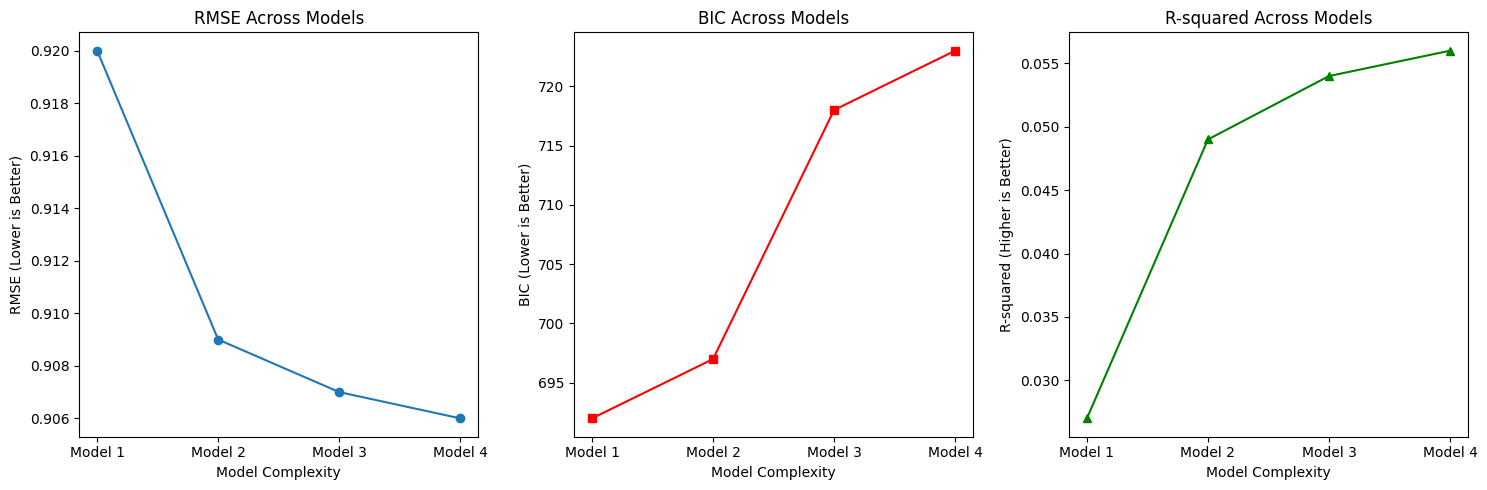

In [8]:
# Extract values for plotting
models_list = full_sample_metrics_fa_df["Model"]
rmse_values = full_sample_metrics_fa_df["RMSE (Full Sample)"].astype(float)
bic_values = full_sample_metrics_fa_df["BIC (Full Sample)"].astype(float)
r_squared_values = full_sample_metrics_fa_df["R-squared"].astype(float)

# subplots for visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot RMSE
axes[0].plot(models_list, rmse_values, marker='o', linestyle='-', label="RMSE")
axes[0].set_title("RMSE Across Models")
axes[0].set_xlabel("Model Complexity")
axes[0].set_ylabel("RMSE (Lower is Better)")

# Plot BIC
axes[1].plot(models_list, bic_values, marker='s', linestyle='-', color='r', label="BIC")
axes[1].set_title("BIC Across Models")
axes[1].set_xlabel("Model Complexity")
axes[1].set_ylabel("BIC (Lower is Better)")

# Plot R-squared
axes[2].plot(models_list, r_squared_values, marker='^', linestyle='-', color='g', label="R-squared")
axes[2].set_title("R-squared Across Models")
axes[2].set_xlabel("Model Complexity")
axes[2].set_ylabel("R-squared (Higher is Better)")
plt.tight_layout()
plt.show()


The figure valides well on what we have discussed above based on the table results.